# Reconstructing the booking history of the *UHCW* dataset
The [University Hospitals - Coventry & Warwickshire](https://www.uhcw.nhs.uk) (UHCW) has set up an online [portal](https://www.swiftqueue.co.uk/uhcw.php) to facilitate the booking of blood tests appointments in 18 centers around Coventry (UK).  


Available appointments have been recorded in the dataset `appointments.csv`.  A preliminary investigation of the dataset is done in `UHCW_EDA.ipynb`.

In this notebook we reconstruct the booking history of all appointments in all centers.

## Imports

In [1]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions

In [2]:
def cartesianProduct(left, right):
    """Returns Cartesian product of dataframe.
    From https://stackoverflow.com/a/53699013/9472676 with some arrangement:
    """
    # Rename columns if "key" already exists.
    if "key" in list(left.columns):
        key_x = "key_x"
    else:
        key_x = ""
    if "key" in list(right.columns):
        key_y = "key_x"
    else:
        key_y = ""
    new_key = hash("".join(list(left.columns) + list(right.columns)))
    left.rename(index=str, columns={"key": str(new_key)}, inplace=True)
    right.rename(index=str, columns={"key": str(new_key)}, inplace=True)
    # Calculate Cartesian product
    df_cartesian = left.assign(key=1).merge(
        right.assign(key=1), on='key'
    ).drop('key', 1)
    # Rename columns back to "key" if they had been changed
    left.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    right.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    if (key_x != "") and (key_y != ""):
        df_cartesian.rename(index=str, columns={str(new_key)+"_x": "key_x"}, inplace=True)
        df_cartesian.rename(index=str, columns={str(new_key)+"_y": "key_y"}, inplace=True)
    else:
        df_cartesian.rename(index=str, columns={str(new_key): "key"}, inplace=True)
    return df_cartesian


In [3]:
def spot_action(df, col='key'):
    """
    Detects booking and cancellation of dataframe.
    
    Parameter
    ---------
    df: dataframe with 0's and 1's
    
    Returns
    -------
    df, modified in place, replacing a transition from 0 to 1 with "cancel",
    a transition from 1 to 0 with "book",
    and "none" otherwise.
    """
    df[col] = df[col] - df[col].shift(1)
    df[col].fillna(method='bfill', inplace=True)
    df[col] = df[col].astype(int)
    df[col] = df[col].apply(lambda delta: "cancel" if delta == 1 else ("book" if delta == -1 else "none"))
    return df

## Data
Read in the `csv` file.

In [4]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
filename = 'sample_appointments.csv'  # appointments.csv
foldername = 'Data/UHCW'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
print("Number of records: {0}.".format(raw_data.shape[0]))
print("Column names:\n{}".format("\n".join(raw_data.columns)))

Wednesday 06 February 2019, 10:51:01
Size of data file: 291MB.
Loading data...
Number of records: 5117059.
Column names:
appointment timestamp
center age group
center id
test type
grab timestamp
CPU times: user 2.62 s, sys: 191 ms, total: 2.81 s
Wall time: 2.81 s


Work with a copy `df` of the `raw_data` dataframe.

In [5]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df = raw_data.copy()
df = df[['appointment timestamp', 'center id', 'center age group', 'test type', 'grab timestamp']]
df.columns = ['appointment', 'id', 'age group', 'test type', 'grab']
df['appointment'] = pd.to_datetime(df['appointment'])
df['grab'] = pd.to_datetime(df['grab'])
df = df[['id', 'test type', 'age group', 'grab', 'appointment']]

Wednesday 06 February 2019, 10:51:09
CPU times: user 1.81 s, sys: 182 ms, total: 2 s
Wall time: 1.99 s


## Drop *age group* 
In `UHCW_EDA.ipynb` we have noted that each center serves exactly one age group, so we will ignore the column `age group`:

In [6]:
df.drop('age group', axis=1, inplace=True)

## Working on a restricted dataset
Also in `UHCW_EDA.ipynb`, we have noted that test center `10254` delivers only one test type and has the smallest number of records across all centers.
Therefore, for the sake of simplicity, we will begin with a restricted set containing only the data for center `10254`.
In a second phase, we will consider center `10352` which delivers two test types and has the smallest number of records given its number of test types.

In [9]:
selected_centers = [10352] # [10254] # [10254, 10352]

In [ ]:
df0 = df.loc[df['id'].apply(lambda x: x in selected_centers), df.columns]

## Sorting for convenience of reading

In [ ]:
df0.sort_values(['id', 'test type', 'appointment', 'grab'], inplace=True)

## Selecting an appointment

We will sometimes inspect one particular appointment.  Indeed, closer inspection of the dataset (not shown in `UHCW_EDA.ipynb`) reveals that the following appointment has been cancelled - and booked again.

In [8]:
selected_appointment = datetime.datetime(2019, 1, 17, 11, 30)

In [ ]:
df0[df0['appointment'] == selected_appointment].head()

## Generating the "schedule"
It turns out that the `selected_appointment` was initially not available, butr then later became available.  That is, it had been already booked at the beginning of the dataset and was subsequently cancelled.  To detect this, we generate the `schedule`, that is, the full list of (`grab`, `appointment`) pairs (where `grab` does not occur after `appointment`) from the original dataset `df`.  

We first generate the full list of `grab` timestamps:

In [10]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
grabs = pd.DataFrame()
grabs['grab'] = df['grab'].drop_duplicates().reset_index(drop=True).sort_values(ascending=True)

Wednesday 06 February 2019, 10:51:55
CPU times: user 42.9 ms, sys: 4.56 ms, total: 47.4 ms
Wall time: 45.7 ms


then the full list of `appointment` timestamps:

In [11]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
appointments = pd.DataFrame()
appointments['appointment'] = df['appointment'].drop_duplicates().reset_index(drop=True).sort_values(ascending=True)

Wednesday 06 February 2019, 10:51:57
CPU times: user 60.5 ms, sys: 6.44 ms, total: 67 ms
Wall time: 64.9 ms


Then we calculate their Cartesian product and keep only the relevant side of the diagonal:

In [12]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule = cartesianProduct(grabs, appointments)
schedule.query('grab <= appointment', inplace=True)

Wednesday 06 February 2019, 10:52:07
CPU times: user 591 ms, sys: 73.1 ms, total: 664 ms
Wall time: 662 ms


By inspection we may now see the `grab` timestamps which are missing in `df` for the `selected_appointment`:

In [ ]:
schedule[schedule['appointment'] == selected_appointment].head()

Now we compare `df0` against `schedule` to spot the missing rows:

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df0_compare = pd.merge(
    schedule,
    df0[['grab', 'appointment']].assign(key=1),
    on=['appointment', 'grab'],
    how='outer'
)
df0_compare.fillna(0, inplace=True)
df0_compare['key'] = df0_compare['key'].astype(int)

A `0` indicates that the (`grab`, `appointment`) pair is missing in `df0`, and a `1` that it was there.  For instance, we can inspect the records corresponding to the `selected_appointment`:

In [ ]:
df0_compare[df0_compare['appointment'] == selected_appointment].head()

A transition from `0` to `1` represents a cancellation, and a transition from `1` to `0` represents a booking:

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df0_action = df0_compare.groupby(['appointment']).apply(spot_action)

To get the history we filter out the rows with `none`:

In [ ]:
df0_history = df0_action.loc[df0_action['key'] != "none", :]

Finally we extract the booking history for the `selected_appointment`:

In [ ]:
df0_history[df0_history['appointment'] == selected_appointment]

We can visualize the booking history for all the appointments at the selected center, where bookings are in blue and cancellations in red:

In [ ]:
df0_bookings = df0_history.loc[df0_history['key'] == 'book', ['appointment', 'grab']]
df0_cancellations = df0_history.loc[df0_history['key'] == 'cancel', ['appointment', 'grab']]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6));
df0_bookings.plot(x='appointment', y='grab', style='.b', ax=ax);
df0_cancellations.plot(x='appointment', y='grab', style='.r', ax=ax);
ax.set_xlabel("appointment");
ax.set_ylabel("booking/cancellation");
ax.get_legend().remove()
ax.set_title("Booking & cancellation history for center {}".format(selected_centers[0]), fontsize=18);
ax.grid()

<font size=6>*To be contined.*</font>

# Reconstruct *entire* booking history (of *all* appointments in *all* centers)?

We will now revisit what we did above for one test center in a way that will make it possible to apply to the entire dataset.  First, we restrict `df` to a smaller subset (e.g. records for one test center):

In [13]:
df = df.loc[df['id'].apply(lambda x: x in selected_centers), df.columns]

We duplicate `schedule`, one for each (`id`, `test type`) pair: 

In [14]:
%%time 
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule_duplicate = pd.concat(
    [schedule.assign(id=id_item).assign(type=type_item)
     for id_item in list(df['id'].unique())
     for type_item in list(df['test type'].unique())
     ]
    )

Wednesday 06 February 2019, 10:53:41
CPU times: user 107 ms, sys: 36 ms, total: 143 ms
Wall time: 141 ms


In [15]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule_duplicate.rename(index=str, columns={'type': 'test type'}, inplace=True)

Wednesday 06 February 2019, 10:53:44
CPU times: user 298 ms, sys: 18.9 ms, total: 317 ms
Wall time: 315 ms


In [16]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule_duplicate = schedule_duplicate[['id', 'test type', 'grab', 'appointment']]

Wednesday 06 February 2019, 10:53:48
CPU times: user 25.2 ms, sys: 4.08 ms, total: 29.2 ms
Wall time: 27.5 ms


In [17]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
schedule_duplicate.sort_values(['id', 'test type', 'grab', 'appointment'],
    inplace=True
)

Wednesday 06 February 2019, 10:53:50
CPU times: user 391 ms, sys: 90 ms, total: 481 ms
Wall time: 478 ms


In [18]:
schedule.info()

<class 'pandas.core.frame.DataFrame'>
Index: 928075 entries, 0 to 930619
Data columns (total 2 columns):
grab           928075 non-null datetime64[ns]
appointment    928075 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 21.2+ MB


In [19]:
schedule_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1856150 entries, 0 to 930619
Data columns (total 4 columns):
id             int64
test type      object
grab           datetime64[ns]
appointment    datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 70.8+ MB


If we are working with only one test center which delivers only one `test type`, `schedule` and `schedule_duplicate` are essentially the same:

In [ ]:
schedule_duplicate[['grab', 'appointment']].equals(schedule)

The only difference is that `schedule_duplicate` contains extra columns with `id` and `test type`:

In [ ]:
schedule_duplicate[schedule_duplicate['appointment'] == selected_appointment].head()

We now compare the recorded data in `df` against the schedule:

In [20]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df_compare = pd.merge(
    schedule_duplicate,
    df.assign(key=1),
    on=['id', 'test type', 'appointment', 'grab'],
    how='outer'
)
df_compare.fillna(0, inplace=True)
df_compare['key'] = df_compare['key'].astype(int)

Wednesday 06 February 2019, 10:55:48
CPU times: user 400 ms, sys: 101 ms, total: 501 ms
Wall time: 498 ms


In [21]:
df_compare[
    (df_compare['appointment'] == selected_appointment)
    & (df_compare['id'] == selected_centers[0])
].head()

,id,test type,grab,appointment,key
181,10352,Blood Test,2019-01-15 13:40:00,2019-01-17 11:30:00,0
9977,10352,Blood Test,2019-01-15 13:50:00,2019-01-17 11:30:00,0
19773,10352,Blood Test,2019-01-15 14:00:00,2019-01-17 11:30:00,0
29569,10352,Blood Test,2019-01-15 14:10:00,2019-01-17 11:30:00,0
39365,10352,Blood Test,2019-01-15 14:20:00,2019-01-17 11:30:00,0


Calculate the booking history:

In [22]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df_action = df_compare.groupby(['id', 'test type', 'appointment']).apply(spot_action)

Wednesday 06 February 2019, 10:56:18
CPU times: user 32.1 s, sys: 585 ms, total: 32.6 s
Wall time: 32.4 s


In [23]:
df_history = df_action.loc[df_action['key'] != "none", :]

In [25]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 30446 to 1846525
Data columns (total 5 columns):
id             97 non-null int64
test type      97 non-null object
grab           97 non-null datetime64[ns]
appointment    97 non-null datetime64[ns]
key            97 non-null object
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 4.5+ KB


In [26]:
df_bookings = df_history.loc[df_history['key'] == 'book', ['id', 'test type', 'appointment', 'grab']]
df_cancellations = df_history.loc[df_history['key'] == 'cancel', ['id', 'test type', 'appointment', 'grab']]

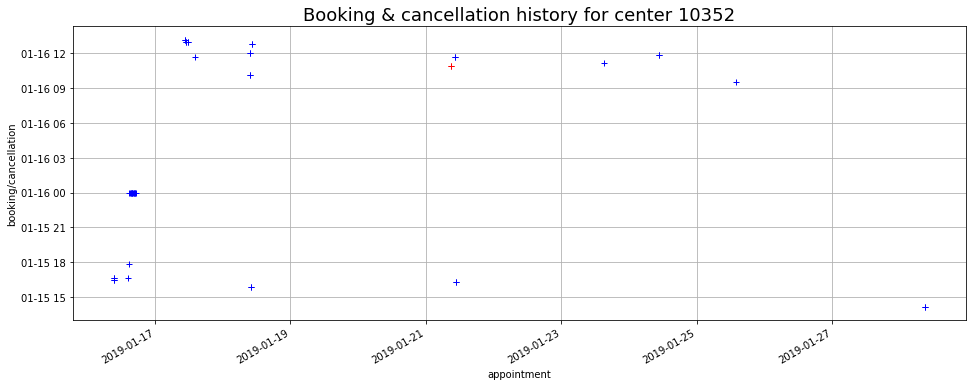

In [32]:
fig, ax = plt.subplots(figsize=(16, 6));
df_bookings.query('appointment < datetime.datetime(2019, 2, 1)').plot(x='appointment', y='grab', style='+b', ax=ax);
df_cancellations.query('appointment < datetime.datetime(2019, 2, 1)').plot(x='appointment', y='grab', style='+r', ax=ax);
ax.set_xlabel("appointment");
ax.set_ylabel("booking/cancellation");
ax.get_legend().remove()
ax.set_title("Booking & cancellation history for center {}".format(selected_centers[0]), fontsize=18);
ax.grid()

===============================================================================

===============================================================================

Inspect the records for the selected center and selected appointment:

In [ ]:
df_history[
    (df_history['appointment'] == selected_appointment)
    &
    (df_history['id'] == selected_centers[0])
].head()

We recover the same results as in our preliminary investigation.

===============================================================================

In [ ]:
df0_cart = schedule_duplicate[schedule_duplicate['appointment'] == selected_appointment]

In [ ]:
df0 = df[df['appointment'] == selected_appointment]

In [ ]:
df0.assign(key=1).head()

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df_compare = pd.merge(
    schedule_duplicate,
    df.assign(key=1),
    on=['id', 'test type', 'appointment', 'grab'],
    how='outer'
)

In [ ]:
df_compare[df_compare['appointment'] == selected_appointment].head()

In [ ]:
#%%time
#print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
#df_compare = pd.merge(
#    df.assign(key=1),
#    schedule_duplicate,
#    how='outer',
#    #how='right',
#    #left_on=['grab', 'appointment', 'id', 'test type'],
#    #right_on=['grab', 'appointment', 'id', 'test type']
##    on=['id', 'test type', 'appointment', 'grab']
#    #on=['appointment', 'grab']
#)

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df_compare.fillna(0, inplace=True)

In [ ]:
df_compare[df_compare['appointment'] == selected_appointment].head()

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))
df_compare['key'] = df_compare['key'].astype(int)

In [ ]:
df_compare[df_compare['appointment'] == selected_appointment].head()

In [ ]:
%%time
print(datetime.datetime.now().strftime("%A %d %B %Y, %H:%M:%S"))

df_action = df_compare.groupby(['id', 'test type', 'appointment']).apply(spot_action)

In [ ]:
df_action[df_action['appointment'] == selected_appointment].head()

In [ ]:
df_history = df_action.loc[df_action['key'] != "none", :]

In [ ]:
df_history.info()

In [ ]:
df_history[df_history['appointment'] == selected_appointment]